In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import os
import cv2
import matplotlib.pyplot as plt
import imutils
from tqdm import tqdm

In [3]:
os.listdir('Data/Art_Nouveau_Modern')

['nicholas-roerich_maleine-s-room-1913.jpg',
 'henri-de-toulouse-lautrec_miss-may-belfort-welcoming-1895.jpg',
 'raphael-kirchner_single-items-6.jpg',
 'nicholas-roerich_sketch-of-costumes-for-snow-maiden-3.jpg',
 'pablo-picasso_the-cries-of-virgins-1900.jpg',
 'nicholas-roerich_crown-of-the-world-1921.jpg',
 'ivan-bilibin_magazine-russian-opera-in-paris-1930.jpg',
 'raphael-kirchner_girls-faces-with-red-border-3.jpg',
 'heorhiy-narbut_playing-cards-1917-1.jpg',
 'raphael-kirchner_the-embrace.jpg',
 'ferdinand-hodler_self-portrait-1912-1.jpg',
 'boris-kustodiev_on-the-volga-1910.jpg',
 'nicholas-roerich_king-s-room-1913.jpg',
 'felix-vallotton_portrait-of-french-writer-victor-charbonnel-1898.jpg',
 'aubrey-beardsley_the-yellow-book-1894.jpg',
 'nicholas-roerich_yaroslavl-entrance-to-the-st-nicholas-wet-church-1903.jpg',
 'jozsef-rippl-ronai_aunt-manci-1913.jpg',
 'zinaida-serebriakova_in-ballet-dressing-room-1924.jpg',
 'j.-e.-h.-macdonald_the-little-falls-1919.jpg',
 'ivan-bilibin_che

In [4]:
#os.listdir('Data/Art_Nouveau_Modern')
image = cv2.imread('Data/Art_Nouveau_Modern/raphael-kirchner_santoy-1900-2.jpg')

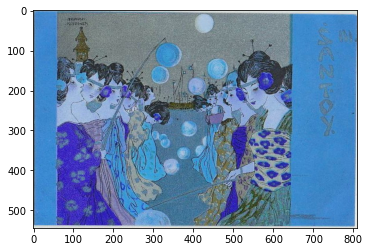

In [5]:
plt.imshow(image)

In [6]:
width, height = keras.preprocessing.image.load_img('Data/Art_Nouveau_Modern/raphael-kirchner_santoy-1900-2.jpg').size
img_nrows = 512
img_ncols = int(width * img_nrows / height)

In [7]:
height

544

In [8]:
def gram_matrix(x):
    x = tf.transpose(x)
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    gram = tf.reshape(gram,(tf.shape(gram)[0], -1))
    return gram

In [9]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [10]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [11]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [12]:
outputs_dict.keys()

dict_keys(['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool'])

In [13]:
feature_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [14]:
def style_encoding(image_path,feature_extractor):
    image_tensor = preprocess_image(image_path)
    features = feature_extractor(image_tensor)
    layer_features = features['block5_pool']
    gram = gram_matrix(layer_features)
    gram = np.array(tf.reshape(gram, [-1]))
    return gram


def color_encoding(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    features = []
    (h, w) = image.shape[:2]
    (cX, cY) = (int(w * 0.5), int(h * 0.5))
    segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),(0, cX, cY, h)]
    
    (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
    
    ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
    
    cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
    
    for (startX, endX, startY, endY) in segments:
        
# construct a mask for each corner of the image, subtracting
# the elliptical center from it
        cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
        cornerMask = cv2.subtract(cornerMask, ellipMask)
        # extract a color histogram from the image, then update the
        # feature vector
        hist = histogram(image, mask = cornerMask)
        features.extend(hist)
    hist = histogram(image, ellipMask)
    features.extend(hist)
    return np.array(features)
    

In [16]:
def histogram(image, mask):
    # extract a 3D color histogram from the masked region of the
    # image, using the supplied number of bins per channel
    hist = cv2.calcHist([image], [0, 1, 2], mask, (8,10,9),
        [0, 180, 0, 256, 0, 256])
    # normalize the histogram if we are using OpenCV 2.4
    if imutils.is_cv2():
        hist = cv2.normalize(hist).flatten()
    # otherwise handle for OpenCV 3+
    else:
        hist = cv2.normalize(hist, hist).flatten()
    # return the histogram
    return hist

In [17]:
#### Dataframe Outline

#### [Primary Key{image path}, Folder_encompassed{Folder path}, Encodings]

In [18]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'Data')

In [19]:
data_dir

'/Users/pradyumnaelavarthi/Downloads/Projects/DSC/Similar_art/Data'

In [20]:
list_of_folders = [i for i in sorted(os.listdir(data_dir)) if not i.startswith('.')]
list_of_folders[:10], len(list_of_folders)

(['Art_Nouveau_Modern',
  'Baroque',
  'Contemporary_Realism',
  'Cubism',
  'Early_Renaissance',
  'Fauvism',
  'High_Renaissance',
  'Impressionism',
  'Mannerism_Late_Renaissance',
  'Minimalism'],
 22)

In [21]:
enc_dict = {'image_path' : [], 'folder_path' : [], 'encoding' : []}

In [22]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

for path in tqdm(list_of_folders):
    folder_path = os.path.join(data_dir,path)
    list_images = [image for image in sorted(os.listdir(folder_path)) if not image.startswith('.')]
    for image in list_images:
        image_path = os.path.join(folder_path,image)
        style_encs = style_encodings(image_path,feature_extractor)
        color_encs = color_encodings(image_path)
        encs = np.concatenate([style_encs,color_encs])
        enc_dict['image_path'].append(os.path.join(folder_path,image))
        enc_dict['folder_path'].append(folder_path)
        enc_dict['encoding'].append(encs)

  0%|          | 0/22 [03:57<?, ?it/s]


KeyboardInterrupt: 